In [1]:
import numpy as np
import json
import pandas as pd
import os
import matplotlib.pyplot as plt
import umap
import math
import matplotlib.image as mpimg
import matplotlib.patches as mpatches
from matplotlib import colors
import matplotlib.transforms as mtrans
import yaml
from yaml.loader import SafeLoader
from collections import OrderedDict
from scipy.ndimage.measurements import center_of_mass
from verstack.stratified_continuous_split import scsplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import auc, roc_curve, roc_auc_score, accuracy_score
from sklearn.model_selection import cross_val_predict, train_test_split, cross_val_score, cross_validate
from sklearn.svm import LinearSVR, SVC
from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr
import seaborn as sns

In [2]:
# Release3
dir_Release3 = '/neurospin/grip/external_databases/dHCP_CR_JD_2018/Projects/denis/release3_scripts/subjects_file_v4.json'
with open(dir_Release3) as f:
    subjects_R3 = json.load(f)

subjects_R3 = list(subjects_R3.keys())

#Release1
dir_Release1 = "/neurospin/dico/data/bv_databases/dHCP/neurospin/grip/external_databases/dHCP_CR_JD_2018/release1/subjects/dHCP_release1"
subjects_Release1 = os.listdir(dir_Release1)
subjects_R1 = [file[4:15] for file in subjects_Release1]

count=0
file_list = []
for file in subjects_R1:
    if file not in subjects_R3:
        count+=1
        print(file)
        file_list.append(file)
print(count)

CC00069XX12
CC00172BN08
CC00217XX11
CC00338BN17
CC00480XX11
CC00176XX12
CC00334XX13
CC00379XX17
CC00099AN18
CC00422XX10
CC00281BN10
CC00413XX09
CC00216AN10
0312
CC00221XX07
CC00170XX06
CC00172AN08
CC00237XX15
18


In [3]:
d = pd.DataFrame({'Subject': file_list})
d.to_csv('/neurospin/dico/jlaval/data/dHCP_R1_lost_subjects.csv', index=False)

In [3]:
# get the session ids of R3
dir_sessions = '/neurospin/grip/external_databases/dHCP_CR_JD_2018/Projects/denis/release3_scripts/subjects_file_v4.json'
with open(dir_sessions) as f:
    dict_sessions = json.load(f)
sessions = [value['session_id'] for _, value in dict_sessions.items()]

In [4]:
# get birth age list
dir_info_dHCP = '/home/jl274628/Documents/info_dHCP.tsv'
info_dHCP = pd.read_csv(dir_info_dHCP, usecols=['participant_id', 'birth_age', 'session_id'], sep='\t')
# filter over subjects
info_dHCP.drop(info_dHCP[~(info_dHCP['participant_id'].isin(subjects_R3))].index, inplace = True)
#info_dHCP.drop(info_dHCP[(info_dHCP['scan_number']!=1)].index, inplace = True) # not always scan 1
# filter over sessions
info_dHCP.drop(info_dHCP[~(info_dHCP['session_id'].isin(sessions))].index, inplace = True)
info_dHCP.reset_index(drop=True, inplace=True)

names = info_dHCP['participant_id'].tolist()
birth_age = info_dHCP['birth_age'].tolist()
birth_age = np.array(birth_age)
preterm = birth_age < 30
fullterm = birth_age > 37

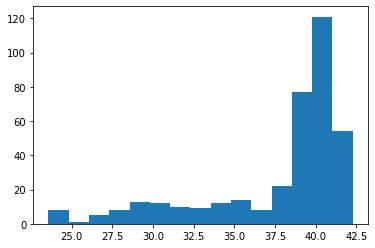

In [5]:
plt.hist(birth_age, bins=15)
plt.show()

In [145]:
# define a stratified split of the dataset
# select uniformly on birth age for regression problem
# make train val test

#first select 10 subjects / wk for 41 > age > 38
subset_dHCP = info_dHCP[(info_dHCP["birth_age"]<=38) | (info_dHCP['birth_age'] > 42)]

for k in (38,39,40,41):
    print(np.sum(birth_age > k))
    subset_k = info_dHCP[(info_dHCP["birth_age"]<=k+1) & (info_dHCP['birth_age'] > k)]
    subset_k = subset_k.sample(n=10)
    subset_dHCP = pd.concat((subset_dHCP, subset_k))

subset_dHCP = subset_dHCP.reset_index()


263
218
147
54


In [ ]:
# 60% for train
X_train, X_val, y_train, y_val = scsplit(subset_dHCP,
                                         subset_dHCP['birth_age'],
                                         stratify=subset_dHCP['birth_age'],
                                         test_size=0.4,
                                         train_size=0.6)

In [ ]:
# 20% for test and 20% for val
subset_val_test = X_val.reset_index()
X_val, X_test, y_val, y_test = scsplit(subset_val_test,
                                       subset_val_test['birth_age'],
                                       stratify=subset_val_test['birth_age'],
                                       test_size=0.5,
                                       train_size=0.5)


In [ ]:
# save train, val, test stratification
save_dir = '/neurospin/dico/jlaval/data/dHCP_155/'
train = X_train['participant_id']
train.to_csv(save_dir+'train_subject.csv', index=False, header=None)
test = X_test['participant_id']
test.to_csv(save_dir+'test_subject.csv', index=False, header=None)
val = X_val['participant_id']
val.to_csv(save_dir+'validation_subject.csv', index=False, header=None)

In [ ]:
# modify preterm_labels.csv
## add other_thresholds
## add birth_age

save_dir = '/neurospin/dico/data/deep_folding/current/datasets/dHCP_374_subjects/crops/2mm/S.T.s.baby/mask/preterm_labels.csv'
labels_csv = info_dHCP.copy()
labels_csv.columns=['Subject', 'session_id', 'birth_age']
birth_age = labels_csv['birth_age'].tolist()
birth_age = np.array(birth_age)
preterm28 = (birth_age < 28).astype(int)
labels_csv.insert(loc=3, column='Preterm_28', value=preterm28)
preterm30 = (birth_age < 30).astype(int)
labels_csv.insert(loc=4, column='Preterm_30', value=preterm30)
preterm32 = (birth_age < 32).astype(int)
labels_csv.insert(loc=5, column='Preterm_32', value=preterm32)
preterm34 = (birth_age < 34).astype(int)
labels_csv.insert(loc=6, column='Preterm_34', value=preterm34)
preterm37 = (birth_age < 37).astype(int)
labels_csv.insert(loc=7, column='Preterm_37', value=preterm37)
labels_csv

labels_csv.to_csv(save_dir, index=False, sep=',')

preterm = preterm.astype(int)

df = pd.DataFrame({'Subject': names,
                   'Preterm': preterm})
df.to_csv('/neurospin/dico/data/deep_folding/current/datasets/dHCP_374_subjects/crops/2mm/S.T.s.baby/mask/preterm_labels.csv', sep=',', index=False)

## UMAP

In [6]:
plots_save_dir = '/neurospin/dico/jlaval/plots/Regresser_dHCP_155/'

In [ ]:
## UMAP : SimCLR dHCP, applied to dHCP
# Use new dHCP data
# Load embeddings
#training on dHCP
#dir = '/neurospin/dico/jlaval/Runs/01_deep_supervised/Program/Output/2023-06-09/17-02-23_1/STs_dHCP_374_subjects_embeddings/'
#training on dHCP 155
#dir = '/neurospin/dico/jlaval/Runs/01_deep_supervised/Program/Output/2023-06-13/13-33-26/STs_dHCP_155_embeddings/'
#training on HCP
#dir = '/neurospin/dico/jlaval/Runs/01_deep_supervised/Program/Output/2023-06-12//11-36-38_3/STs_dHCP_embeddings/'
# training on UKB (no post train)
dir = '/neurospin/dico/jlaval/Runs/01_deep_supervised/Program/Output/2023-06-15//14-36-49/STs_dHCP_374_subjects_embeddings/'
# regresser on age : CHEATING !!
#dir = '/neurospin/dico/jlaval/Runs/01_deep_supervised/Program/Output/2023-06-13/13-42-14/STs_dHCP_155_embeddings/'
# UKB pretrain + dHCP 374 train
#dir = '/neurospin/dico/jlaval/Runs/01_deep_supervised/Program/Output/2023-06-16/11-54-27/STs_dHCP_374_subjects_embeddings/'

dir_embeddings = dir+'full_embeddings.csv'
"""
dir_AUC = dir+'Preterm/values.json'
with open(dir_AUC) as f:
    AUC = json.load(f)
    AUC = AUC['cross_val_auc']
    AUC = (AUC[0]-AUC[1], AUC[0]+AUC[1])
"""

cols = [f'dim{k}' for k in range(1,11)]
df_embeddings = pd.read_csv(dir_embeddings, sep=',')
all = df_embeddings[cols]

# fit UMAP
reducer = umap.UMAP()
embeddings = reducer.fit_transform(all)
df_embeddings = pd.DataFrame({'participant_id': df_embeddings['ID'].tolist(),
                              'dim1': embeddings[:, 0],
                              'dim2': embeddings[:, 1]})

# merge with labels (birth age)
df = pd.merge(info_dHCP, df_embeddings)

In [ ]:
def plot_umap(df, label, thresholds, colors, ax, AUC=(0,0), transparency_full_term=0.3, scatter_size=10):

    dims = ['dim1', 'dim2']

    # plot in decreasing label order
    df_sliced = df.loc[df[label] > thresholds[-1]]
    umap = df_sliced[dims]
    ax.scatter(umap['dim1'], umap['dim2'], label = f'{label} > {thresholds[-1]}', alpha=transparency_full_term, color=colors[-1], s=scatter_size)

    for idx in range(len(thresholds)-1, 0, -1):

        df_sliced = df.loc[(df[label] <= thresholds[idx]) & (df[label] > thresholds[idx-1])]
        umap = df_sliced[dims]
        ax.scatter(umap['dim1'], umap['dim2'], label = f'{thresholds[idx-1]} < {label} < {thresholds[idx]}', color=colors[idx], s=scatter_size)

    df_sliced = df.loc[df[label] <= thresholds[0]]
    umap = df_sliced[dims]
    ax.scatter(umap['dim1'], umap['dim2'], label = f'{label} < {thresholds[0]}', color=colors[0], s=scatter_size)

    #ax.set_title(f'UMAP on dHCP (AUC: {AUC[0]:.2f} - {AUC[1]:.2f})')
    ax.set_title(f'UMAP on dHCP')
    ax.legend()

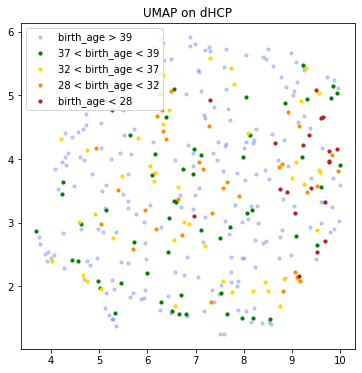

In [212]:
#thresholds=[28, 32, 36] # preterm
#thresholds=[28]
thresholds=[28, 32, 37, 39]
colors=['firebrick', 'darkorange', 'gold', 'green', 'royalblue']
label = 'birth_age'

fig, ax = plt.subplots(figsize=(6,6))
plot_umap(df, label, thresholds, colors, ax)
#plt.savefig(plots_save_dir+'UMAP.jpg', facecolor='white')
plt.show()

In [ ]:
# see UMAP with skel volume label, and center of mass ?
# compute AUC to objectify ?
# also use brain volume
dir_skels = '/neurospin/dico/data/deep_folding/current/datasets/dHCP_374_subjects/crops/2mm/S.T.s.baby/mask/Rskeleton.npy'
dir_names = '/neurospin/dico/data/deep_folding/current/datasets/dHCP_374_subjects/crops/2mm/S.T.s.baby/mask/Rskeleton_subject.csv'
skels = np.load(dir_skels)
skels = skels[:,:,:,:,0] > 0
names = pd.read_csv(dir_names)

In [ ]:
def normalize(arr):
    return ((np.array(arr) - np.min(arr)) / (np.max(arr) - np.min(arr)))

df_labels = pd.DataFrame({'participant_id': names['Subject'].tolist()})

#use the order of names, and correct the order when merging the dataframes
#volume skel
volumes = normalize([np.sum(skel) for skel in skels])
df_labels.insert(loc=1, column='skel volume', value=volumes)
#center_of_mass # distances to center should be used instead ...
center_of_mass_x = normalize([center_of_mass(skel)[0] for skel in skels])
df_labels.insert(loc=2, column='center of mass x', value=center_of_mass_x)
center_of_mass_y = normalize([center_of_mass(skel)[1] for skel in skels])
df_labels.insert(loc=3, column='center of mass y', value=center_of_mass_y)
center_of_mass_z = normalize([center_of_mass(skel)[2] for skel in skels])
df_labels.insert(loc=4, column='center of mass z', value=center_of_mass_z)
#volume of hull
hull_volumes = []
for subject in names['Subject']:
    session = info_dHCP.loc[info_dHCP['participant_id']==subject]['session_id'].tolist()[0]
    session = str(session)
    dir_arg = '/neurospin/grip/external_databases/dHCP_CR_JD_2018/Projects/denis/release3_morpho_bids/'+ 'sub-'+subject+'/'+'ses-'+session+'/anat/t1mri/default_acquisition/default_analysis/folds/3.1/default_session_auto/R'+subject+'_default_session_auto.arg'
    with open(dir_arg, 'r') as file:
        data = file.read()
        volume = float(data.split('\n')[19].split(' ')[-1])
        hull_volumes.append(volume)
hull_volumes = normalize(hull_volumes)
df_labels.insert(loc=5, column='hull volume', value=hull_volumes)

df_bias = pd.merge(df, df_labels)

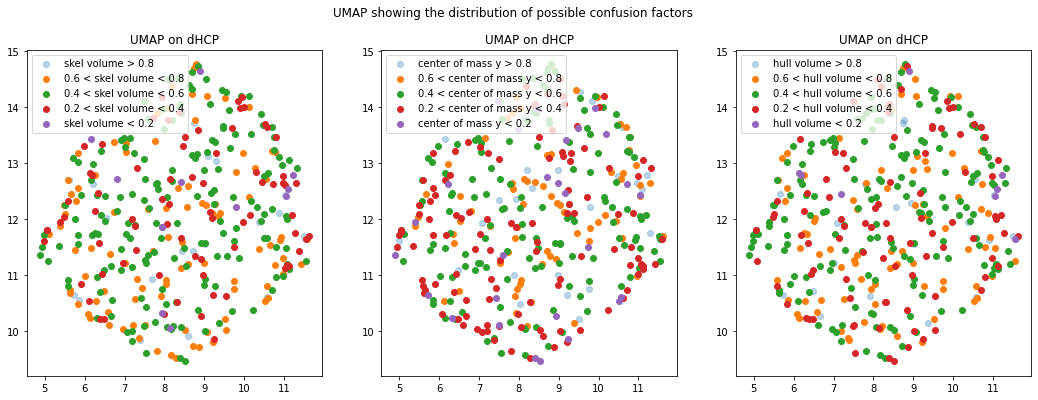

In [ ]:
thresholds = [0.2, 0.4, 0.6, 0.8]

fig,axs = plt.subplots(ncols=3, figsize=(18, 6))
for idx, label in enumerate(['skel volume', 'center of mass y', 'hull volume']):
    plot_umap(df_bias, label, thresholds, axs[idx])
plt.suptitle('UMAP showing the distribution of possible confusion factors')
#plt.savefig(plots_save_dir+'UMAP_params_labels.jpg', facecolor='white')
plt.show()

In [ ]:
# Model trained on HCP, UMAP fitted on HCP, applied to HCP + dHCP

# Load embeddings HCP
dir = '/neurospin/dico/jlaval/Runs/01_deep_supervised/Program/Output/2023-06-12/11-36-38_3/STs_HCP_embeddings/'
dir_embeddings = dir+'full_embeddings.csv'

cols = [f'dim{k}' for k in range(1,11)]
df_embeddings = pd.read_csv(dir_embeddings, sep=',')
all = df_embeddings[cols]

# fit UMAP
reducer = umap.UMAP()
embeddings = reducer.fit_transform(all)
df_embeddings_0 = pd.DataFrame({'dim1': embeddings[:, 0],
                                'dim2': embeddings[:, 1]})

# add embeddings dHCP
dir = '/neurospin/dico/jlaval/Runs/01_deep_supervised/Program/Output/2023-06-12/11-36-38_3/STs_dHCP_embeddings/'
dir_embeddings = dir+'full_embeddings.csv'

df_embeddings = pd.read_csv(dir_embeddings, sep=',')
all = df_embeddings[cols]
embeddings = reducer.transform(all)
df_embeddings_1 = pd.DataFrame({'participant_id': df_embeddings['ID'].tolist(),
                               'dim1': embeddings[:, 0],
                               'dim2': embeddings[:, 1]})
# merge with labels (birth age)
df = pd.merge(info_dHCP, df_embeddings_1)

## UMAP HCP

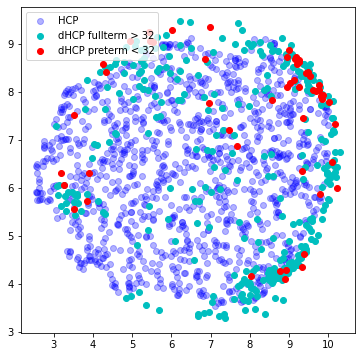

In [ ]:
#split preterm and not preterm
threshold=32
label='birth_age'
#thresholds=[28,30,32,34]
df_preterm = df.loc[df[label] <= threshold]
df_fullterm = df.loc[df[label] > threshold]

fig, ax = plt.subplots(figsize=(6,6))

plt.scatter(df_embeddings_0['dim1'], df_embeddings_0['dim2'], color='b', label='HCP', alpha=0.3)
#plt.scatter(df_embeddings_1['dim1'], df_embeddings_1['dim2'], color='r', label='dHCP')
#plt.scatter(df['dim1'], df['dim2'], color='r', label='dHCP')
plt.scatter(df_fullterm['dim1'], df_fullterm['dim2'], color='c', label=f'dHCP fullterm > {threshold}')
plt.scatter(df_preterm['dim1'], df_preterm['dim2'], color='r', label=f'dHCP preterm < {threshold}')

plt.legend()
plt.show()

## UMAP UKB

In [35]:
# Model trained on UKB, UMAP fitted on UKB, applied to UKB + dHCP

# Load embeddings UKB
dir = '/neurospin/dico/jlaval/Runs/01_deep_supervised/Program/Output/2023-06-15/14-36-49/STs_UkBioBank_embeddings/'
dir_embeddings = dir+'full_embeddings.csv'

cols = [f'dim{k}' for k in range(1,11)]
df_embeddings = pd.read_csv(dir_embeddings, sep=',')
all = df_embeddings[cols]

# fit UMAP
reducer = umap.UMAP()
embeddings = reducer.fit_transform(all)
df_embeddings_0 = pd.DataFrame({'dim1': embeddings[:, 0],
                                'dim2': embeddings[:, 1]})

In [36]:
# add embeddings dHCP
dir = '/neurospin/dico/jlaval/Runs/01_deep_supervised/Program/Output/2023-06-15/14-36-49/STs_dHCP_374_subjects_embeddings/'
dir_embeddings = dir+'full_embeddings.csv'

df_embeddings = pd.read_csv(dir_embeddings, sep=',')
all = df_embeddings[cols]
embeddings = reducer.transform(all)
df_embeddings_1 = pd.DataFrame({'participant_id': df_embeddings['ID'].tolist(),
                               'dim1': embeddings[:, 0],
                               'dim2': embeddings[:, 1]})
# merge with labels (birth age)
df = pd.merge(info_dHCP, df_embeddings_1)

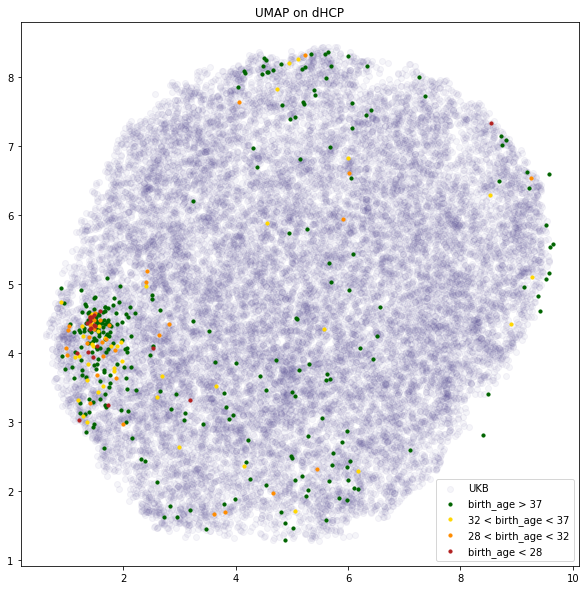

In [37]:
#split preterm and not preterm
label='birth_age'
#thresholds=[37,34,32,30,28]
thresholds=[28,32,37]
colors=['firebrick', 'darkorange', 'gold', 'darkgreen']

fig, ax = plt.subplots(figsize=(10,10))

plt.scatter(df_embeddings_0['dim1'], df_embeddings_0['dim2'], color='darkslateblue', label='UKB', alpha=0.05)
plot_umap(df, label, thresholds, colors, ax, transparency_full_term=1)

plt.legend()
plt.show()

NB: hierarchical clusters ? Beware, there are less preterms, so much less likely to fall outside the high density area

In [8]:
# let's visualize where morphometric parameters lend
# let's concatenate morpho data from each subject using the brainvisa files to make sure session is right
# subjects and session in info_dHCP

# let's make a csv for the sulcus and save it
sulcus = 'S.T.s._right'
morpho_params = ['hull_junction_length_talairach', 'maxdepth_talairach', 'GM_thickness', 'opening', 'meandepth_talairach', 'surface_talairach']
morpho_save = '/neurospin/dico/data/deep_folding/current/datasets/dHCP_374_subjects/morphometry/'

In [9]:
"""
# create and save df
morpho_df = pd.DataFrame(columns=morpho_params)

for idx, (id, session, _) in info_dHCP.iterrows():
    morpho_dir = f'/neurospin/grip/external_databases/dHCP_CR_JD_2018/Projects/denis/release3_morpho_bids/sub-{id}/ses-{session}/anat/t1mri/default_acquisition/default_analysis/folds/3.1/default_session_auto/{id}_default_session_auto_sulcal_morphometry.csv'
    morpho = pd.read_csv(morpho_dir, sep=';')
    morpho_sulcus = morpho.loc[morpho['sulcus']==sulcus][morpho_params]
    morpho_df = morpho_df.append(morpho_sulcus)

morpho_df.to_csv(morpho_save+sulcus+'_morpho.csv', index=False)
"""

"\n# create and save df\nmorpho_df = pd.DataFrame(columns=morpho_params)\n\nfor idx, (id, session, _) in info_dHCP.iterrows():\n    morpho_dir = f'/neurospin/grip/external_databases/dHCP_CR_JD_2018/Projects/denis/release3_morpho_bids/sub-{id}/ses-{session}/anat/t1mri/default_acquisition/default_analysis/folds/3.1/default_session_auto/{id}_default_session_auto_sulcal_morphometry.csv'\n    morpho = pd.read_csv(morpho_dir, sep=';')\n    morpho_sulcus = morpho.loc[morpho['sulcus']==sulcus][morpho_params]\n    morpho_df = morpho_df.append(morpho_sulcus)\n\nmorpho_df.to_csv(morpho_save+sulcus+'_morpho.csv', index=False)\n"

In [10]:
# load df
morpho_df = pd.read_csv(morpho_save+sulcus+'_morpho.csv')

In [11]:
df_morpho = pd.concat([df, morpho_df.set_index(df.index)], axis=1)

NameError: name 'df' is not defined

In [19]:
df_morpho['length_talairach']=np.array(df_morpho.surface_talairach) / np.array(df_morpho.meandepth_talairach)
df_morpho

participant_id  session_id  birth_age       dim1      dim2  \
0      CC00065XX08       18600  40.428571   8.825103  9.134972   
1      CC00067XX10       20200  40.000000  11.327730  6.472746   
2      CC00068XX11       20701  40.428571  12.521317  7.635367   
3      CC00071XX06       27000  39.857143   9.313518  5.508737   
4      CC00073XX08       27800  40.714286   9.339298  8.901389   
..             ...         ...        ...        ...       ...   
369    CC01194XX16      149530  42.000000   9.657625  5.578317   
370    CC01198XX20      140930  41.571429  10.726634  6.522618   
371    CC01199XX21      141130  39.857143  11.540770  7.675285   
372    CC01206XX10      143530  41.857143  11.216462  7.090633   
373    CC00908XX17       37030  40.428571   9.088011  8.547869   

     hull_junction_length_talairach  maxdepth_talairach  GM_thickness  \
0                            126.86               23.24          2.17   
1                            137.62               24.48          2.19   
2                            129.46               29.52          2.20   
3                            129.58               24.68          2.03   
4                            122.08               21.60          2.29   
..                              ...                 ...           ...   
369                          110.78               31.54          2.10   
370                          149.84               30.52          2.01   
371                          135.28               24.98          2.11   
372                          189.54               27.90          2.09   
373                          166.26               26.60          2.30   

     opening  meandepth_talairach  surface_talairach  length_talairach  
0       0.83                13.26            3222.21        243.002262  
1       0.68                15.49            3734.54        241.093609  
2       0.01                18.37            3757.16        204.526946  
3       0.60                12.96            3383.46        261.069444  
4       0.41                12.95            2979.77        230.098069  
..       ...                  ...                ...               ...  
369     0.12                18.00            4292.77        238.487222  
370     0.83                16.16            4229.32        261.715347  
371     0.53                15.10            3794.80        251.311258  
372     0.75                15.70            4798.73        305.651592  
373     0.83                15.67            4935.77        314.982131  

[374 rows x 12 columns]

In [21]:
morpho_params_=morpho_params+['length_talairach']
colors=['red', 'orange', 'gold', 'yellowgreen', 'royalblue']

"""
fig, axs = plt.subplots(figsize=(30,10*len(morpho_params_)//3), ncols=3, nrows=len(morpho_params_)//3+1)

for idx, label in enumerate(morpho_params_):

    # use linearly spaced quantiles for plot
    thresholds = np.nanquantile(df_morpho[label].tolist(), np.linspace(0, 1, 6))[1:-1]
    # keep one decimal place for plot
    thresholds = (100*thresholds).astype(int)/100

    axs[idx//3, idx%3].scatter(df_embeddings_0['dim1'], df_embeddings_0['dim2'], color='darkslateblue', label='UKB', alpha=0.05)
    plot_umap(df_morpho, label, thresholds, colors, axs[idx//3, idx%3], transparency_full_term=1, scatter_size=3)

plt.legend()
plt.show()
"""

"\nfig, axs = plt.subplots(figsize=(30,10*len(morpho_params_)//3), ncols=3, nrows=len(morpho_params_)//3+1)\n\nfor idx, label in enumerate(morpho_params_):\n\n    # use linearly spaced quantiles for plot\n    thresholds = np.nanquantile(df_morpho[label].tolist(), np.linspace(0, 1, 6))[1:-1]\n    # keep one decimal place for plot\n    thresholds = (100*thresholds).astype(int)/100\n\n    axs[idx//3, idx%3].scatter(df_embeddings_0['dim1'], df_embeddings_0['dim2'], color='darkslateblue', label='UKB', alpha=0.05)\n    plot_umap(df_morpho, label, thresholds, colors, axs[idx//3, idx%3], transparency_full_term=1, scatter_size=3)\n\nplt.legend()\nplt.show()\n"

NB: density of babies + the fact that the lower values are plotted after may create false impression of clusters!! Would be smarter to plot according to birth age order, or change scatter size. Beware on UKB map: same issue if high density region and plot order: plot in a random order ?

In [7]:
# compute correlations between morpho and birth age # use sns.pairplot instead
fig, axs = plt.subplots(figsize=(15,5*len(morpho_params_)//3), ncols=3, nrows=len(morpho_params_)//3+1)
birth_age = np.array(df_morpho.birth_age)
for idx, label in enumerate(morpho_params_):
    param = df_morpho[label].to_numpy()
    # remove nans for pearson computation
    nas = np.isnan(param)
    print(f'number of nan for label {label}: {np.sum(nas)}')
    p = pearsonr(birth_age[np.where(~nas)[0]], param[np.where(~nas)[0]])
    ax=axs[idx//3, idx%3]
    ax.set_title(f'Pearson : ({p[0]:.3f}, {p[1]:.3f})')
    ax.scatter(birth_age, param)
    ax.set_xlabel('birth age')
    ax.set_ylabel(label)

plt.tight_layout()
plt.show()  

NameError: name 'morpho_params_' is not defined

In [45]:
# preterm classification on morphometric parameters

threshold=32
#drop nans from dataframe
df_morpho_ = df_morpho.dropna(axis=0)
# labels
Y = (df_morpho_.birth_age < threshold).to_numpy()
# data
X = df_morpho_[morpho_params].to_numpy()

In [16]:
# use different thresholds and cross val, same as usual SVC
threshold=32

# SVC predict_proba
model = SVC(kernel='linear', probability=True, class_weight='balanced',
            max_iter=10000)
#labels_proba = cross_val_predict(model, X, Y, cv=5, method='predict_proba')
#scores = cross_val_score(model, X, Y, cv=5, scoring='roc_auc')
cross_validate
print(scores)
print("%0.2f AUC with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

[0.71164773 0.82102273 0.44034091 0.78409091 0.1078125 ]
0.57 AUC with a standard deviation of 0.27


In [94]:
# model.coef_ when using fit method

array([[ 0.24813976, -0.19422543,  1.76776444,  0.40649184,  0.37821669,
        -0.01649784]])

In [ ]:
curves = roc_curve(Y, labels_proba[:, 1])
roc_auc = roc_auc_score(Y, labels_proba[:, 1])
print(f'AUC birth age < {threshold}: {roc_auc}')

AUC birth age < 28: 0.9442550037064492


In [131]:
# save the morpho params as embeddings for fast processing of SVC
# don't need to care about nans as there are none for STS...

# fake directory in order to use train multiple classifiers...
emb_dir = '/neurospin/dico/jlaval/Runs/01_deep_supervised/Program/Output/2023-06-23/morpho_params/STs_dHCP_374_subjects_embeddings/'

df_embeddings_morpho = df_morpho[['participant_id']+morpho_params]
df_embeddings_morpho.columns=['ID']+[f'dim{k}' for k in range(1,7)]
df_embeddings_morpho.to_csv(emb_dir+'full_embeddings.csv', index=False, sep=',')

In [ ]:
# use advanced morphometric parameters
# use redundant parameters from both analysis to select the right session in second analysis
df_morpho[['participant_id', 'hull_junction_length_talairach']]

# first: positional parameters

# secondl shape parameters

# third: all

KeyError: "['participand_id'] not in index"

In [ ]:
# UMAP UKB but labels param on UKB, with random plotting order (equal partition of each label)

In [ ]:
# add HCP for complete analysis


## Variability analysis

In [21]:
# let's look at the variability of embeddings depending on prematurity

def plot_variability(df_norm, dims, thresholds, bins, subset=-1, center=None):

    # center and normalize embeddings between -1 and 1
    embs = df_norm[dims].to_numpy()
    if center == None: # then compute center of all data
        center = np.array([np.mean(embs[:,k]) for k in range(len(dims))])
    embs = np.array([pos-center for pos in embs])
    embs_maxi = np.array([np.max(np.abs(embs[:,k])) for k in range(len(dims))])
    embs = np.array([[pos[k] / embs_maxi[k] for k in range(len(dims))] for pos in embs])
    df_norm[dims] = embs

    # collect embeddings for each age category
    dict_embeddings = {}
    for idx in range(len(thresholds)+1):
        if idx==0:
            preterm = df_norm.loc[df_norm['birth_age'] < thresholds[0]][dims]
            if subset!=-1:
                preterm = preterm.sample(min(len(preterm),subset))
            preterm = preterm.to_numpy()
            dict_embeddings[f'birth_age < {thresholds[0]}'] = preterm
        elif idx==len(thresholds):
            preterm = df_norm.loc[df_norm['birth_age']>=thresholds[-1]][dims]
            if subset!=-1:
                preterm = preterm.sample(min(len(preterm),subset))
            preterm = preterm.to_numpy()
            dict_embeddings[f'birth_age > {thresholds[-1]}'] = preterm
        else:
            preterm = df_norm.loc[(df_norm['birth_age']>=thresholds[idx-1]) & (df_norm['birth_age']<thresholds[idx])][dims]
            if subset!=-1:
                preterm = preterm.sample(min(len(preterm),subset))
            preterm = preterm.to_numpy()
            dict_embeddings[f'{thresholds[idx-1]} < birth_age < {thresholds[idx]}'] = preterm


    # find maximum distance to center
    maxi = 0
    for idx, (label, distrib) in enumerate(dict_embeddings.items()):
        dist = np.array([np.linalg.norm(elem) for elem in distrib])
        if maxi < np.max(dist):
            maxi = np.max(dist)

    # plot an histogram of distances for each category
    fig, axs = plt.subplots(figsize=(8*(len(thresholds)+1),5), ncols=len(thresholds)+1)
    for idx, (label, distrib) in enumerate(dict_embeddings.items()):
        dist = np.array([np.linalg.norm(elem) for elem in distrib])
        ax = axs[idx]
        ax.hist(dist, bins=bins, range=[0, maxi])
        ax.set_title(label)
        ax.set_xlabel('distance to center')
        ax.set_ylabel('number of subjects')

    plt.legend()
    plt.tight_layout()

No handles with labels found to put in legend.


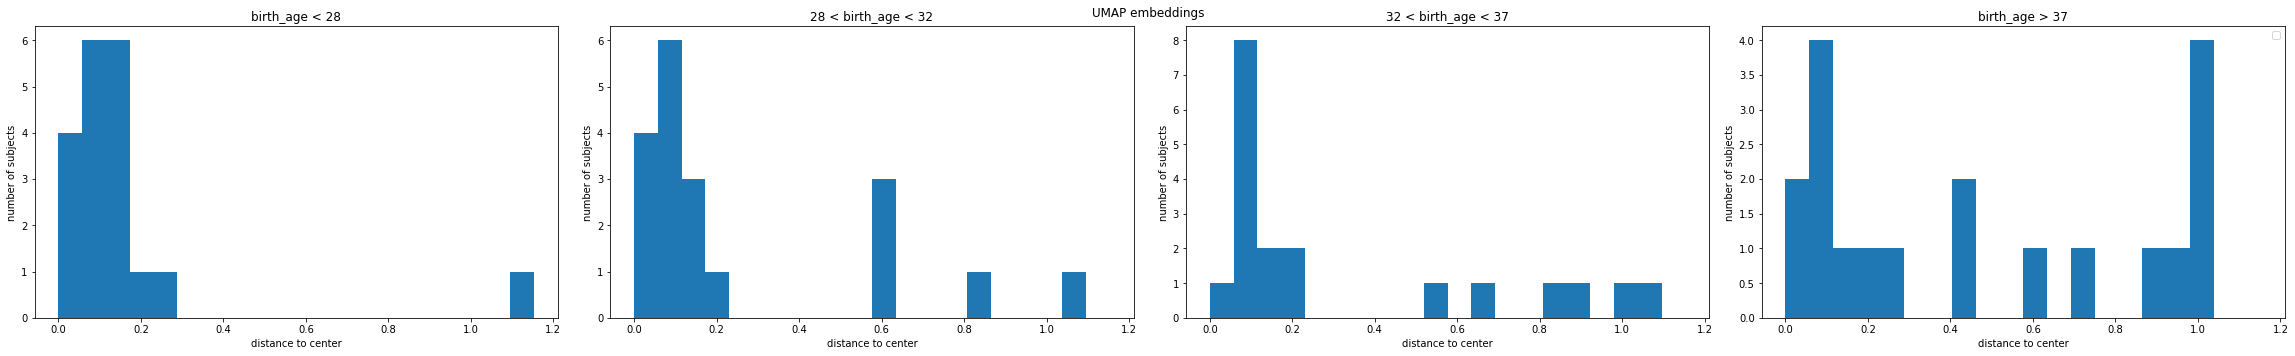

In [39]:
# first UMAP 2D embeddings
df_norm = df.copy()
dims = ['dim1', 'dim2']
thresholds = [28, 32, 37]

plot_variability(df_norm, dims, thresholds, bins=20, subset=19, center=[1.5,4])
plt.suptitle('UMAP embeddings')
plt.show()

No handles with labels found to put in legend.


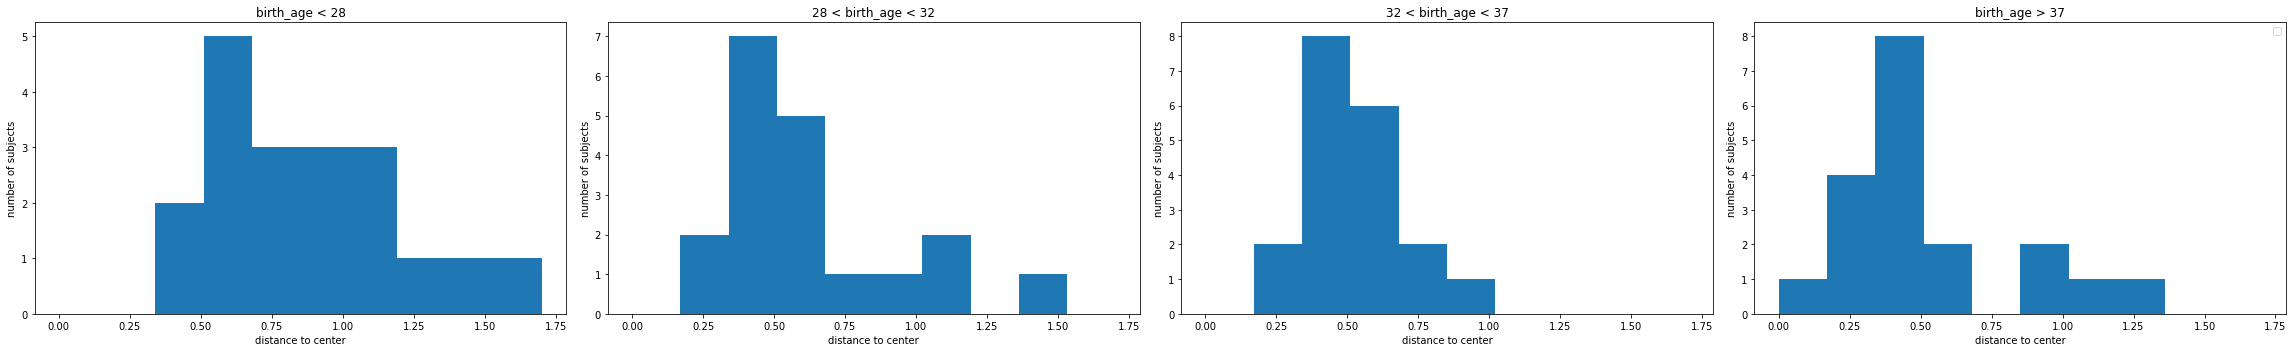

In [46]:
# use morphometry embeddings
dims = [f'dim{k}' for k in range(1,7)]
morpho = df_morpho_[['participant_id', 'birth_age'] + morpho_params]
morpho.columns=['participant_id', 'birth_age'] + dims
thresholds=[28, 32, 37]

plot_variability(morpho, dims, thresholds, bins=10, subset=19)

Peut-être qu'il ne faut pas prendre le centre commun à toutes les données en dimension trop grande à cause du fléau de la dimensionalité qui écrase les distances.
+ Essayer de mesurer la variabilité en subsamplant les données > 37 ??
+ error in plot function ? because the distribution of UMAP changed a bit... Two clusters not as visible ?

In [74]:
# same but use the original embeddings (10 dimensions) # beware curse of dimensionality ?
dims = [f'dim{k}' for k in range(1,11)]
df_embeddings.columns=['participant_id']+dims
df_norm = pd.merge(df[['participant_id', 'birth_age']], df_embeddings)
thresholds=[28, 32, 37]

plot_variability(df_norm, dims, thresholds, bins=20, subset=19)

ValueError: Length mismatch: Expected axis has 3 elements, new values have 11 elements

In [70]:
# Use Pair Plot to visualize the distribution of the data
# select 155 subjects subset
subset_names_0 = pd.read_csv('/neurospin/dico/jlaval/data/dHCP_155/test_subject.csv', header=None)
subset_names_1 = pd.read_csv('/neurospin/dico/jlaval/data/dHCP_155/train_subject.csv', header=None)
subset_names_2 = pd.read_csv('/neurospin/dico/jlaval/data/dHCP_155/validation_subject.csv', header=None)
subset_names = subset_names_0[0].tolist() + subset_names_1[0].tolist() + subset_names_2[0].tolist()
df_corr = df_norm.loc[df_norm['participant_id'].isin(subset_names)]
df_corr = df_corr[['birth_age']+dims]
df_corr.shape

(155, 11)

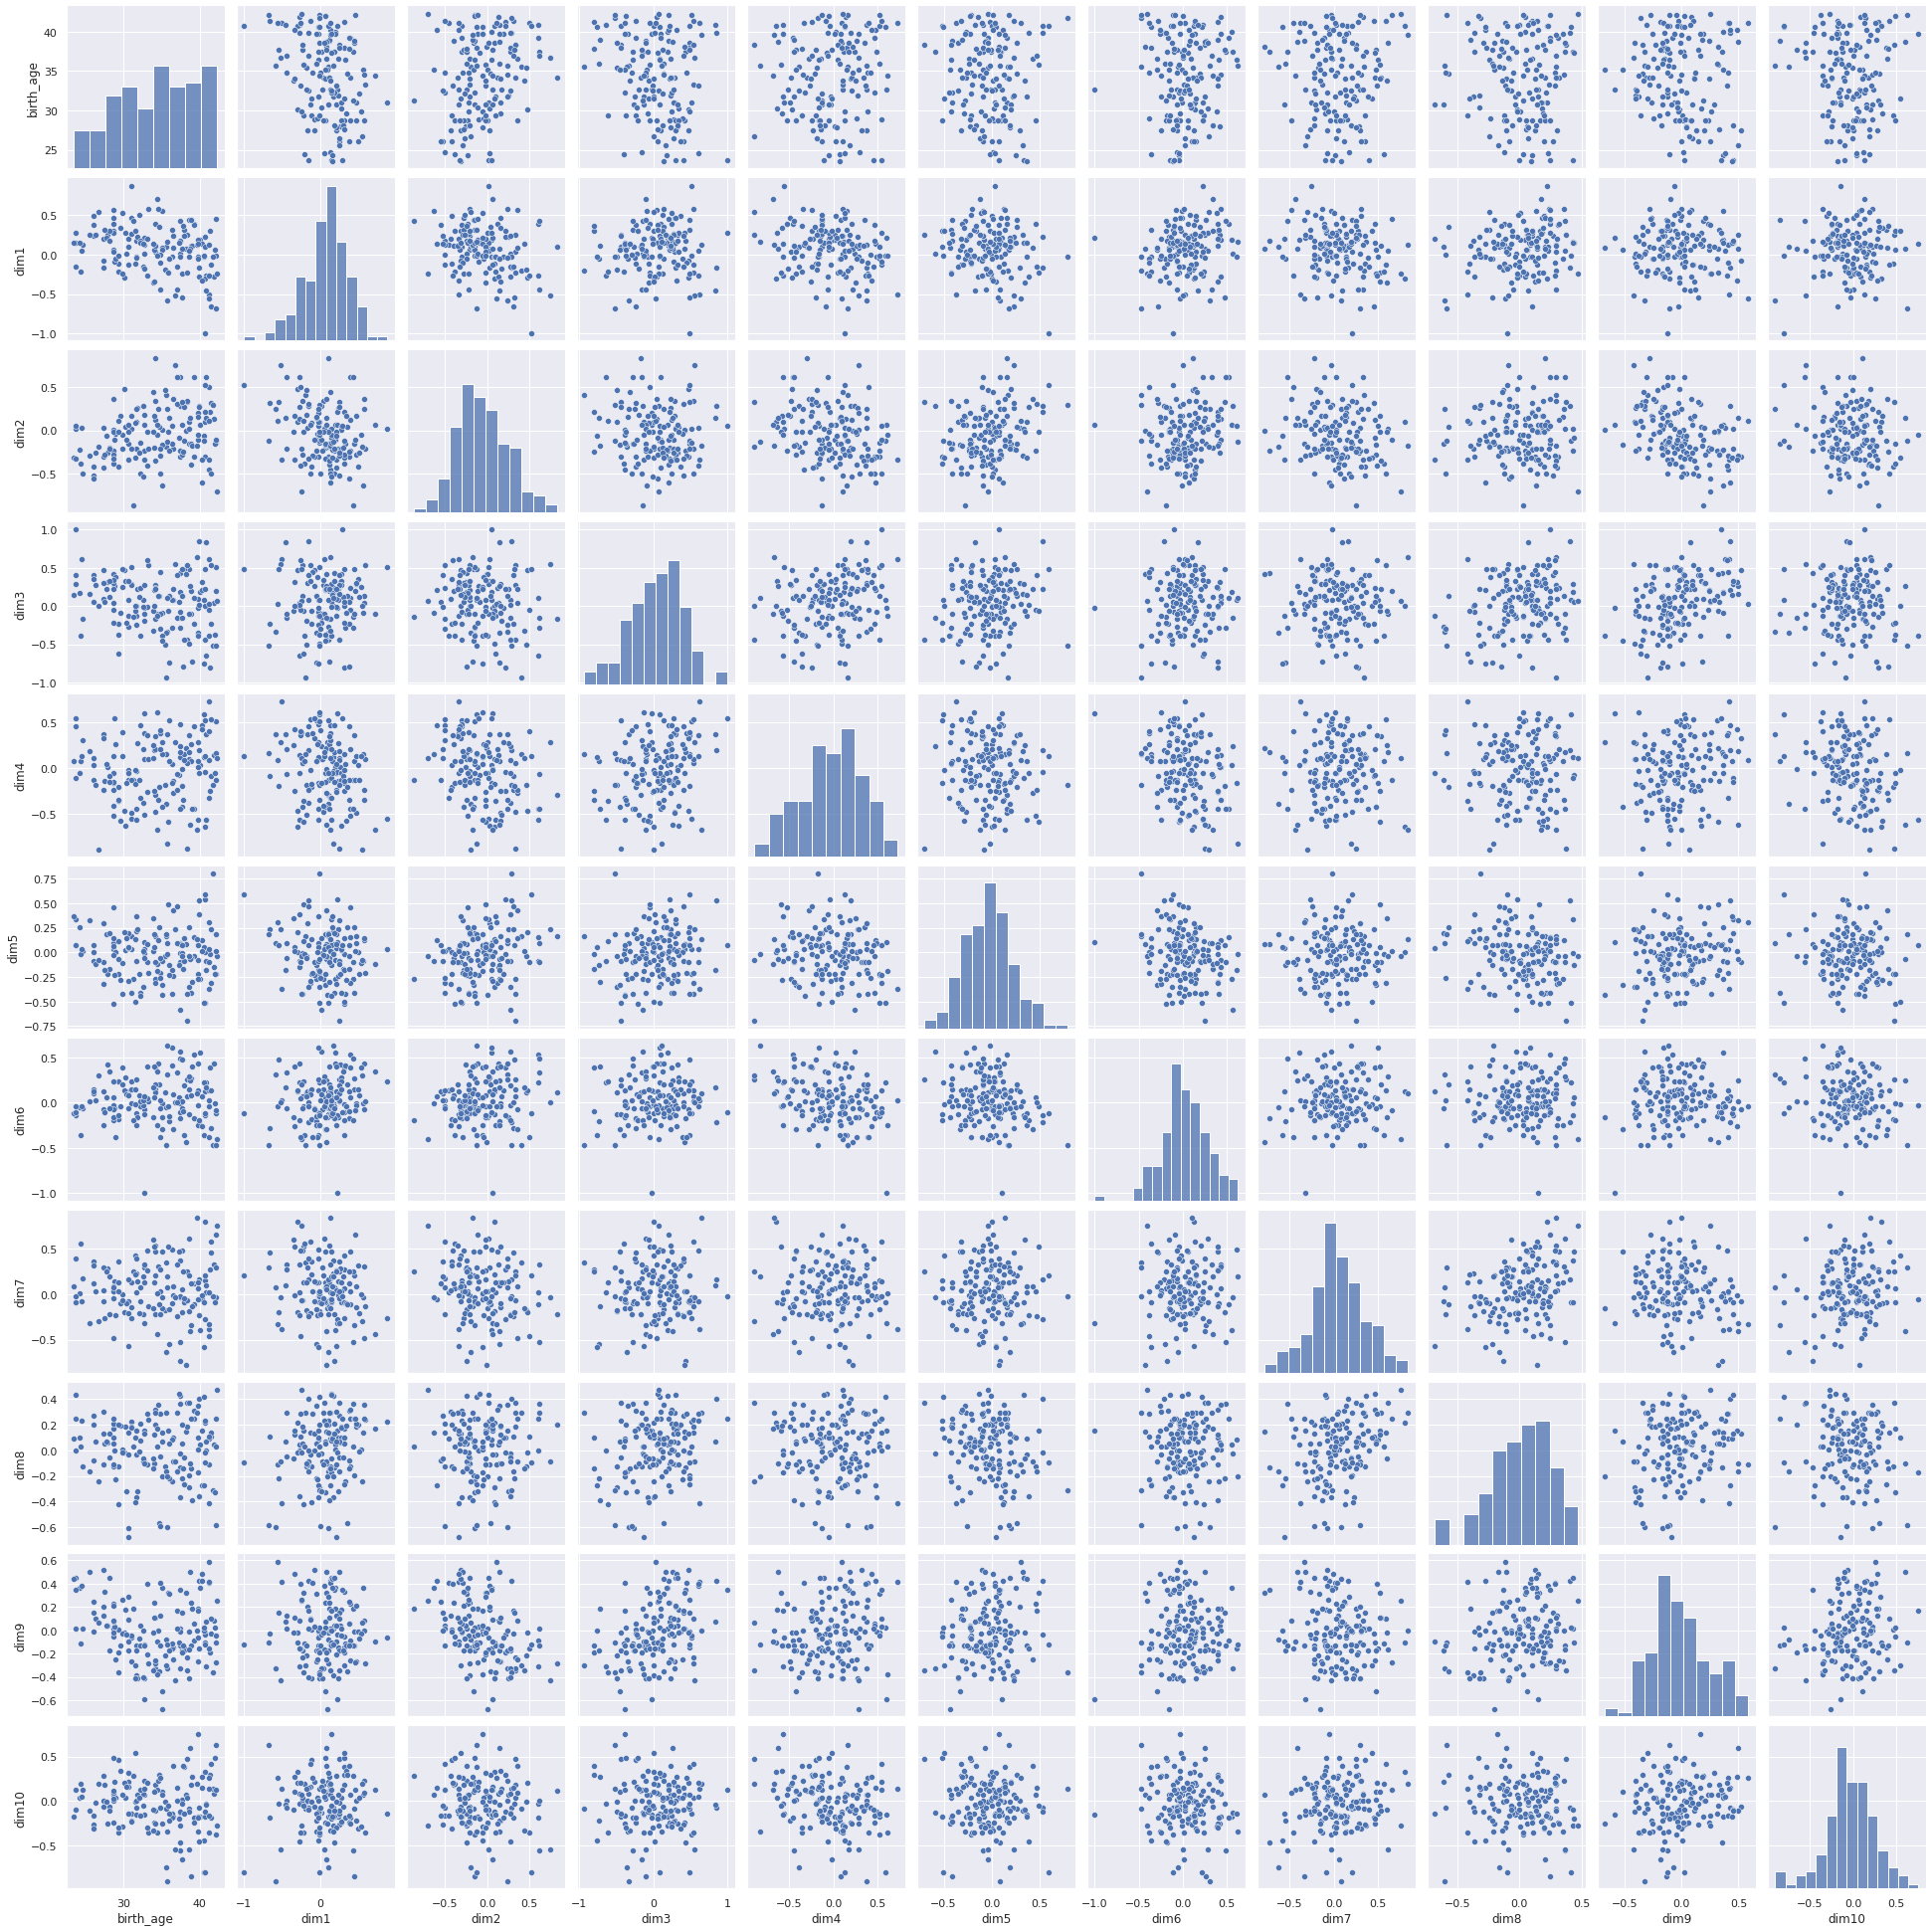

In [50]:
sns.pairplot(df_corr)

<AxesSubplot:>

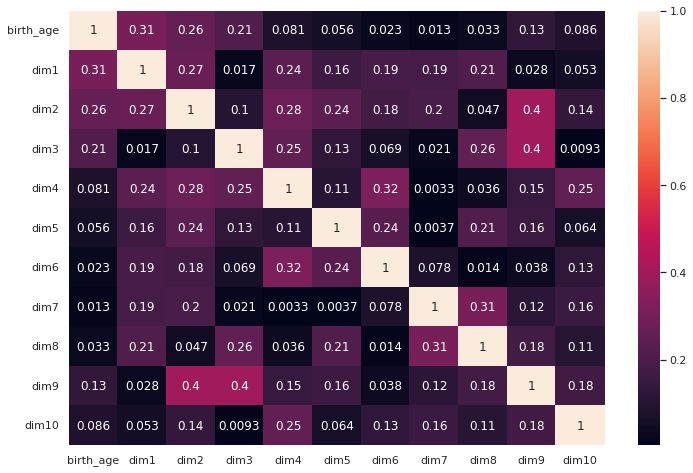

In [71]:
sns.set(rc={'figure.figsize':(12,8)})
sns.heatmap(np.abs(df_corr.corr()), annot=True)

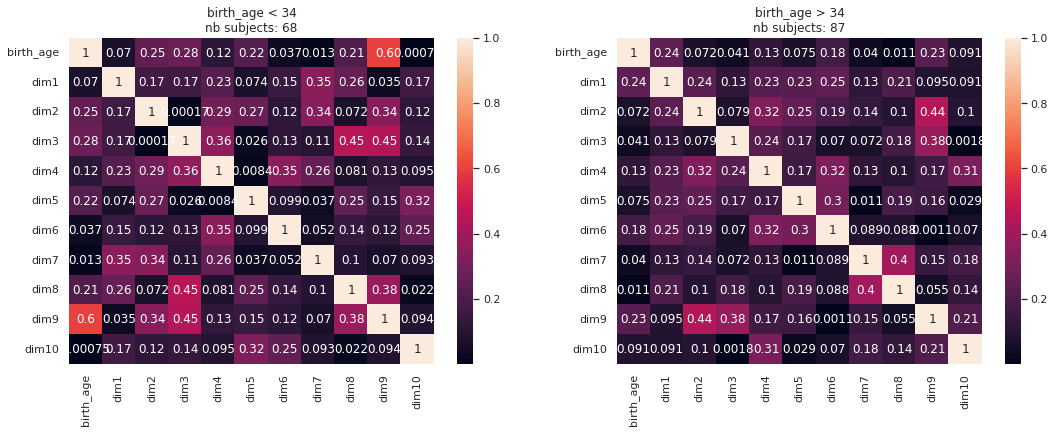

In [72]:
# visualize by age clusters : birth age better correlated to dims at low age
thresholds = [34]
fig, axs = plt.subplots(ncols=len(thresholds)+1, figsize=(9*(len(thresholds)+1),6))
for idx in range(len(thresholds)+1):
    if idx==0:
        df_subset = df_corr.loc[df_corr['birth_age']< thresholds[0]]
        age_range=f"birth_age < {thresholds[0]}"
    elif idx==len(thresholds):
        df_subset = df_corr.loc[df_corr['birth_age']>=thresholds[-1]]
        age_range=f"birth_age > {thresholds[-1]}"
    else:
        df_subset = df_corr.loc[(df_corr['birth_age']<thresholds[idx]) & (df_corr['birth_age']>=thresholds[idx-1])]
        age_range=f"{thresholds[idx-1]} < birth_age < {thresholds[idx]}"
    
    sns.heatmap(np.abs(df_subset.corr()), annot=True, ax=axs[idx])
    axs[idx].set_title(age_range+f'\nnb subjects: {df_subset.shape[0]}')

correlation birth_age / dim9: -0.604294771693655, pvalue: 4.857730619036193e-08, corrected: 7.772368990457908e-06


Text(0.5, 1.0, 'correlation birth_age / dim9: -0.604294771693655, pvalue: 4.857730619036193e-08, corrected: 7.772368990457908e-06')

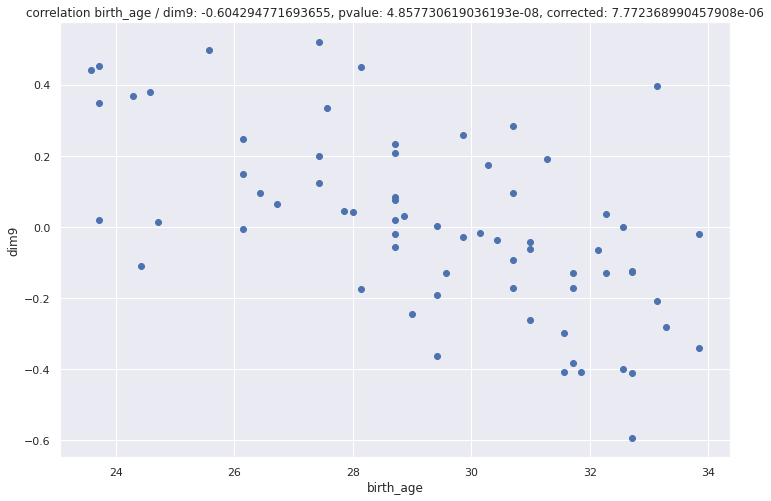

In [67]:
# calculate p-value of correlation between birth_age and dim9 for birth_age < 34 wks
var1 = 'birth_age'
var2 = 'dim9'

df_subset = df_corr.loc[df_corr['birth_age']< 34]

x1 = df_subset[var1]
x2 = df_subset[var2]

pearson = pearsonr(x1, x2)
# Bonferoni
m=160 # 10 correlations per week
corrected_pvalue = pearson[1]*m
print(f'correlation {var1} / {var2}: {pearson[0]}, pvalue: {pearson[1]}, corrected: {corrected_pvalue}')

plt.scatter(x1, x2)
plt.xlabel(var1)
plt.ylabel(var2)
plt.title(f'correlation {var1} / {var2}: {pearson[0]}, pvalue: {pearson[1]}, corrected: {corrected_pvalue}')

<AxesSubplot:>

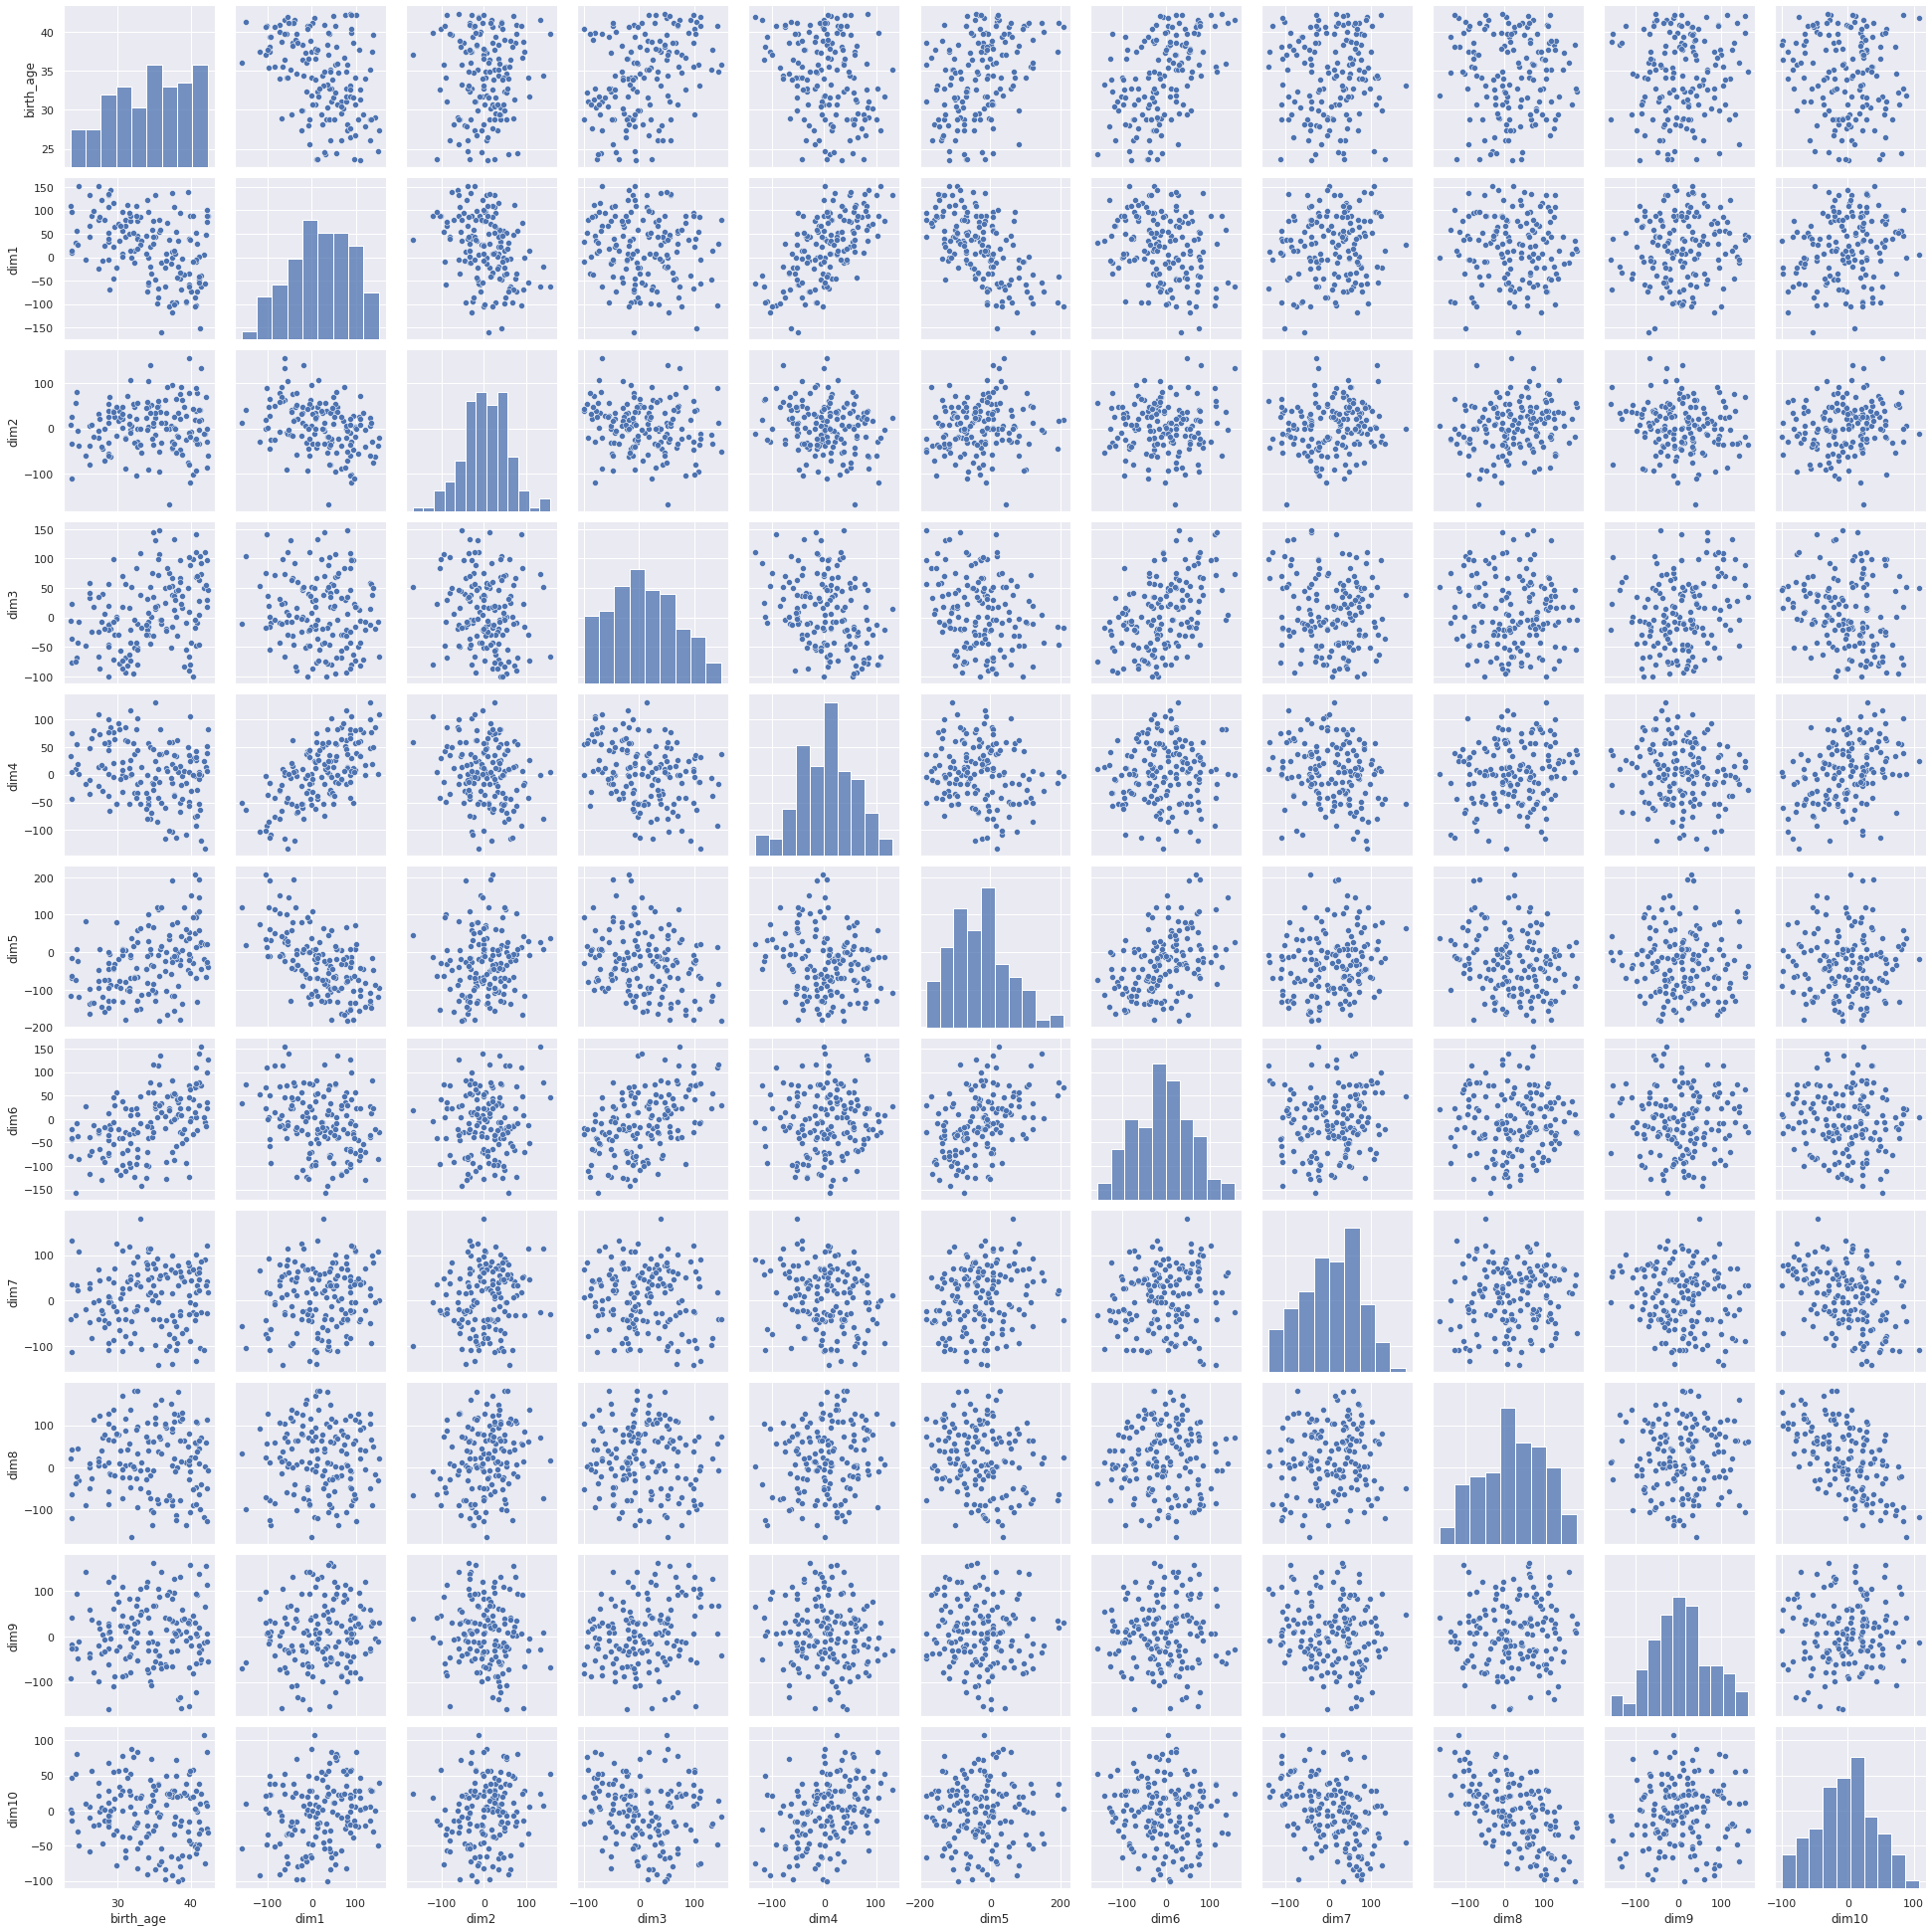

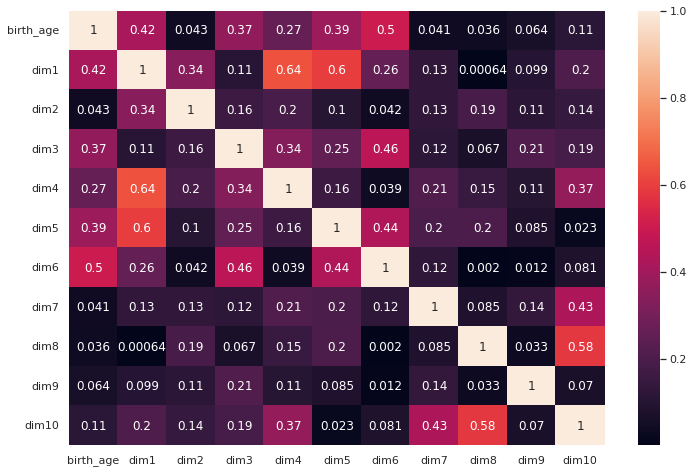

In [83]:
# using dHCP instead of UKB : no interesting correlation ??

dir = '/neurospin/dico/jlaval/Runs/01_deep_supervised/Program/Output/2023-06-09/17-02-23_4/STs_dHCP_374_subjects_embeddings/'

dir_embeddings = dir+'full_embeddings.csv'

cols = [f'dim{k}' for k in range(1,11)]
df_embeddings = pd.read_csv(dir_embeddings, sep=',')

dims = [f'dim{k}' for k in range(1,11)]
df_embeddings.columns=['participant_id']+dims
df_norm = pd.merge(df[['participant_id', 'birth_age']], df_embeddings)

# select 155 subjects subset
subset_names_0 = pd.read_csv('/neurospin/dico/jlaval/data/dHCP_155/test_subject.csv', header=None)
subset_names_1 = pd.read_csv('/neurospin/dico/jlaval/data/dHCP_155/train_subject.csv', header=None)
subset_names_2 = pd.read_csv('/neurospin/dico/jlaval/data/dHCP_155/validation_subject.csv', header=None)
subset_names = subset_names_0[0].tolist() + subset_names_1[0].tolist() + subset_names_2[0].tolist()
df_corr = df_norm.loc[df_norm['participant_id'].isin(subset_names)]
df_corr = df_corr[['birth_age']+dims]

# first visu pair plot
sns.pairplot(df_corr)

# heatmap of correlations
fig, ax = plt.subplots()
sns.set(rc={'figure.figsize':(12,8)})
sns.heatmap(np.abs(df_corr.corr()), annot=True, ax=ax)

correlation birth_age / dim6: 0.5034094955266599, pvalue: 2.4510655612407514e-11, corrected: 3.921704897985202e-09


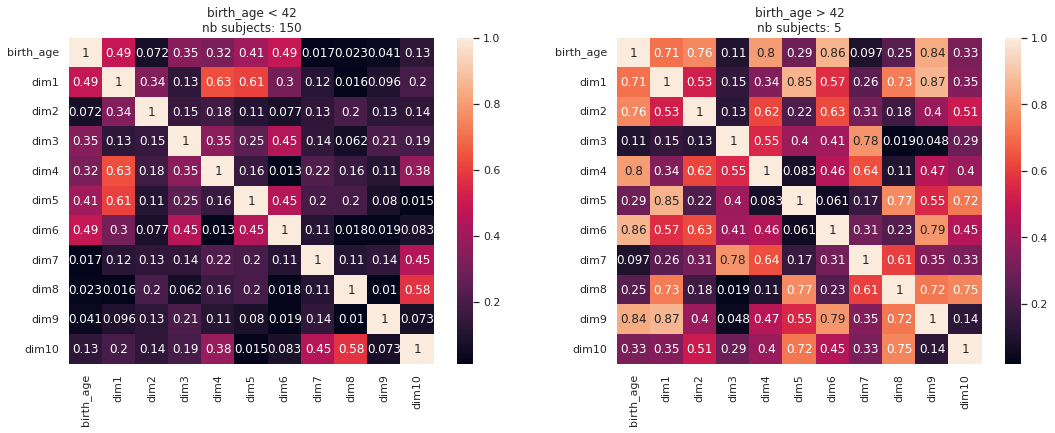

In [86]:
# visualize by age clusters : birth age better correlated to dims at low age
thresholds = [42]
fig, axs = plt.subplots(ncols=len(thresholds)+1, figsize=(9*(len(thresholds)+1),6))
for idx in range(len(thresholds)+1):
    if idx==0:
        df_subset = df_corr.loc[df_corr['birth_age']< thresholds[0]]
        age_range=f"birth_age < {thresholds[0]}"
    elif idx==len(thresholds):
        df_subset = df_corr.loc[df_corr['birth_age']>=thresholds[-1]]
        age_range=f"birth_age > {thresholds[-1]}"
    else:
        df_subset = df_corr.loc[(df_corr['birth_age']<thresholds[idx]) & (df_corr['birth_age']>=thresholds[idx-1])]
        age_range=f"{thresholds[idx-1]} < birth_age < {thresholds[idx]}"
    
    sns.heatmap(np.abs(df_subset.corr()), annot=True, ax=axs[idx])
    axs[idx].set_title(age_range+f'\nnb subjects: {df_subset.shape[0]}')

# calculate p-value of correlation between birth_age and dim9 for birth_age < 34 wks
var1 = 'birth_age'
var2 = 'dim6'

#df_subset = df_corr.loc[df_corr['birth_age']< 34]
df_subset = df_corr.copy()

x1 = df_subset[var1]
x2 = df_subset[var2]

pearson = pearsonr(x1, x2)
# Bonferoni
m=160 # 10 correlations per week
corrected_pvalue = pearson[1]*m
print(f'correlation {var1} / {var2}: {pearson[0]}, pvalue: {pearson[1]}, corrected: {corrected_pvalue}')

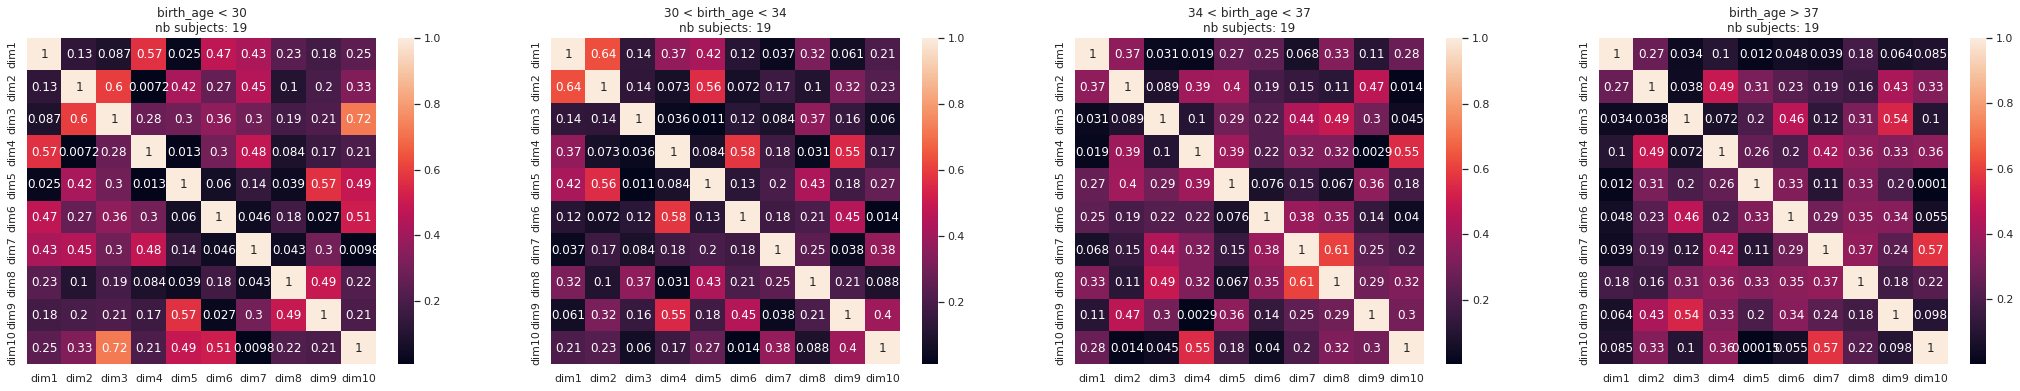

In [111]:
# measure degree of variability in different age ranges by looking at correlations between variables
# take subsets
subset=19
thresholds = [30, 34, 37]
fig, axs = plt.subplots(ncols=len(thresholds)+1, figsize=(9*(len(thresholds)+1),6))
for idx in range(len(thresholds)+1):
    if idx==0:
        df_subset = df_corr.loc[df_corr['birth_age']< thresholds[0]]
        age_range=f"birth_age < {thresholds[0]}"
    elif idx==len(thresholds):
        df_subset = df_corr.loc[df_corr['birth_age']>=thresholds[-1]]
        age_range=f"birth_age > {thresholds[-1]}"
    else:
        df_subset = df_corr.loc[(df_corr['birth_age']<thresholds[idx]) & (df_corr['birth_age']>=thresholds[idx-1])]
        age_range=f"{thresholds[idx-1]} < birth_age < {thresholds[idx]}"

    df_subset = df_subset.sample(min(len(df_subset),subset))
    sns.heatmap(np.abs(df_subset[dims].corr()), annot=True, ax=axs[idx])
    axs[idx].set_title(age_range+f'\nnb subjects: {df_subset.shape[0]}')

not obvious in dimension 10 that varibility goes down

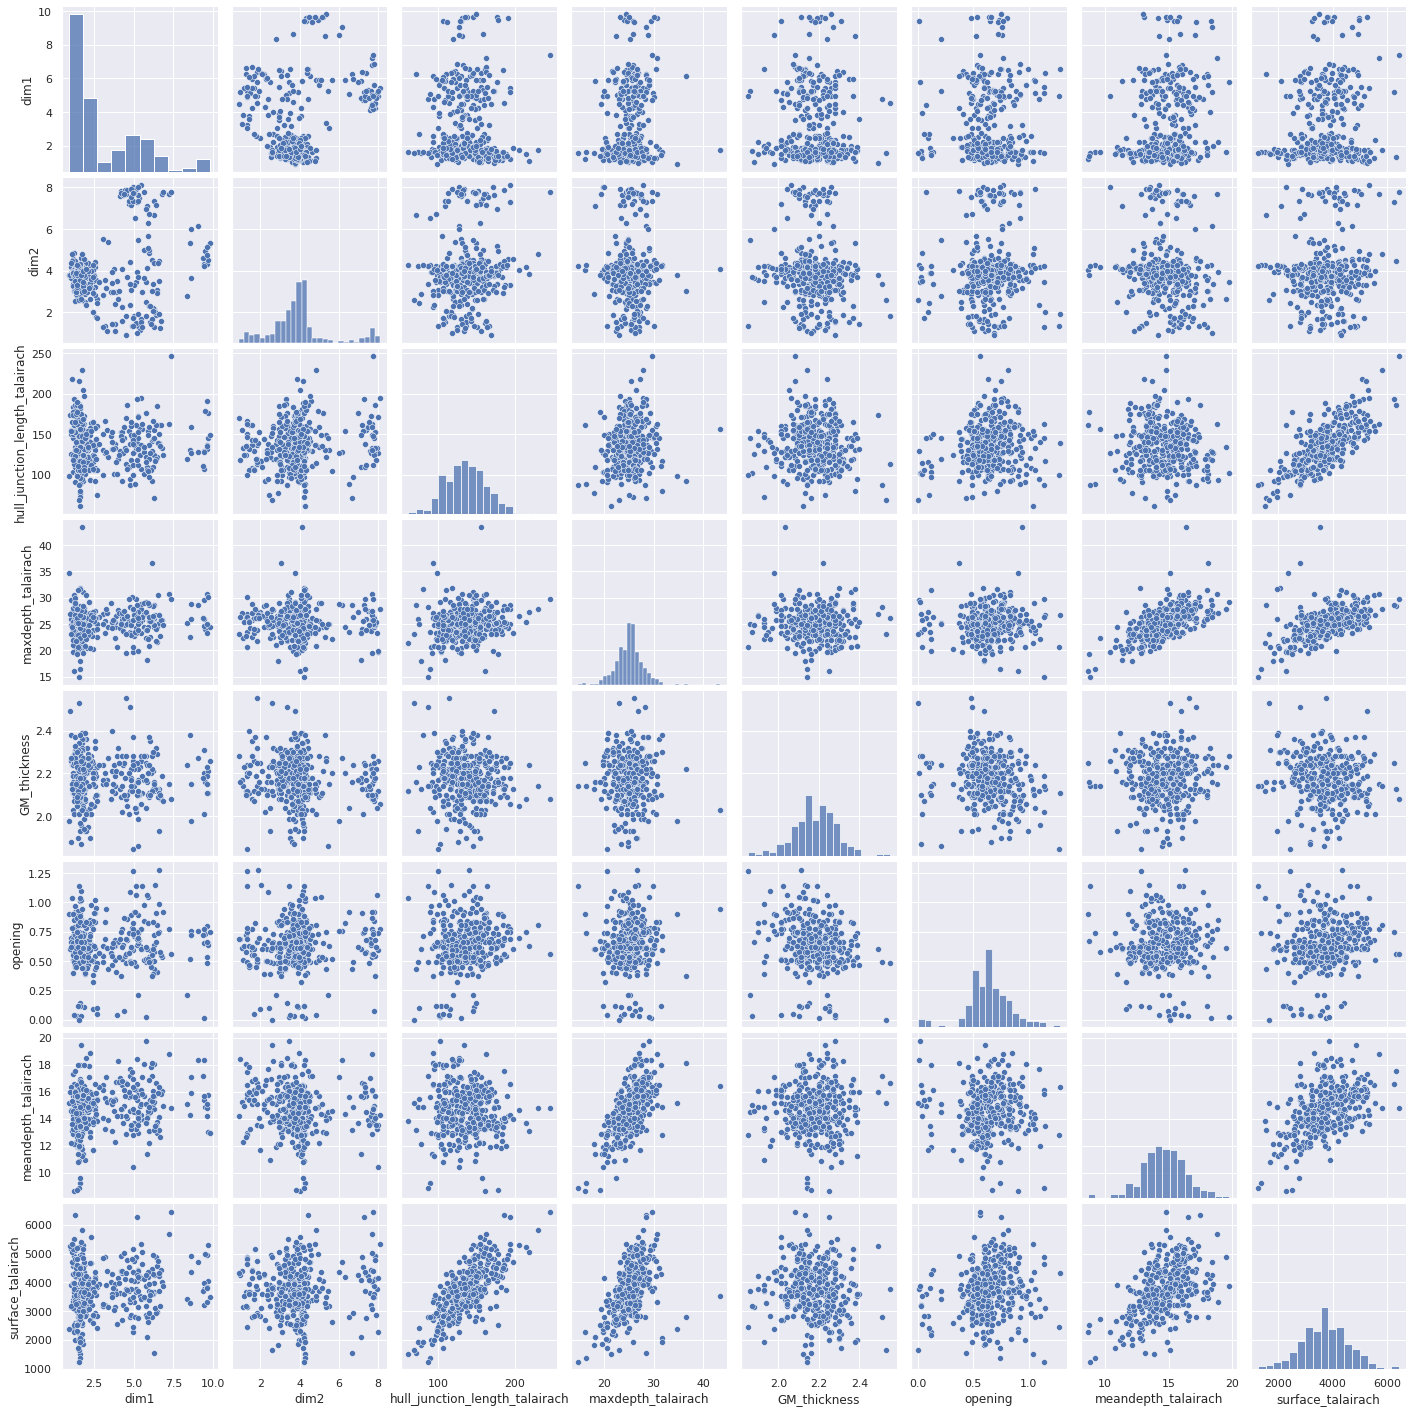

In [116]:
# does the UMAP encode morpho params ? visualize correlations... same for 10dim embeddings ? Not obvious to see anything...
df_correl = pd.merge(df_morpho_, df)[['dim1', 'dim2']+morpho_params]
sns.pairplot(df_correl)

# Plot AUCs of different models

In [16]:
#plot all models (require to merge the group the dataframes in a dictionnary)

def plot_models_perf(dict_to_plot,
                    save_dir,
                    title,
                    xlabel,
                    legend_title='',
                    save_fig=True,
                    normalize=True):

    #legend
    patches=[]
    for name, (_, color) in dict_to_plot.items():
        patch = mpatches.Patch(color=color, label=name)
        patches.append(patch)

    #plot
    fig,ax = plt.subplots(figsize=(8,6))

    for idx, (name, (df, color)) in enumerate(dict_to_plot.items()):
        #tr = offset_plot(idx*3, fig=fig)
        sns.pointplot(data=df, x=xlabel, y='AUC', color=color, markers='s', linestyles='', ax=ax).set(title=title)
        sns.stripplot(data=df, x=xlabel, y='AUC', color=color, marker='v', ax=ax)

    #offset the distributions for a same model
    nb_test_sets = len(dict_to_plot.keys())
    for idx in range(nb_test_sets):
        offset = mtrans.ScaledTranslation(0.15*idx, 0, ax.figure.dpi_scale_trans)
        nb_coll = len(ax.collections)
        start_offset_idx, end_offset_idx = idx*nb_coll // nb_test_sets, (idx+1)*nb_coll // nb_test_sets
        for k in range(start_offset_idx, end_offset_idx): #don't really understand the collection organization
            #first offset the points
            trans = ax.collections[k].get_transform()
            ax.collections[k].set_transform(trans + offset)
            #offset the errorbars
            trans = ax.lines[k].get_transform()
            ax.lines[k].set_transform(trans + offset)
    if normalize:
        ax.set_ylim([0.45, 1])
    plt.legend(handles=patches, title=legend_title)
    plt.xticks(rotation=5)
    if save_fig:
        plt.savefig(save_dir, facecolor='white')

In [17]:
#reformat dictionnaries into dataframes for seaborn

def reformat(dict_plot, xlabel):

        df = pd.DataFrame({xlabel: [], 'AUC': []})
        for model, list_values in dict_plot.items():
            for value in list_values:
                new_row = {xlabel: model, 'AUC': value}
                df = df.append(new_row, ignore_index=True)
        
        return df

In [18]:
# AUC lists

AUC_Morpho = {'28': [0.94],
              '32': [0.8],
              '37': [0.69]}

AUC_dHCP = {'28': [0.85, 0.89, 0.80, 0.81, 0.76],
              '32': [0.88, 0.88, 0.83],
              '37': [0.83, 0.81, 0.82]}

AUC_UKB = {'28': [0.84],
              '32': [0.70],
              '37': [0.64]}

AUC_UKB_dHCP = {'28': [0.85],
              '32': [0.79],
              '37': [0.77]}

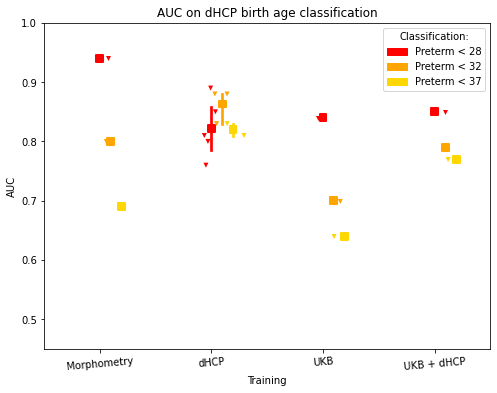

In [20]:
# Resize vs padding #DONE
dict_28 = {"Morphometry": AUC_Morpho['28'],
           "dHCP": AUC_dHCP['28'],
           "UKB": AUC_UKB['28'],
           "UKB + dHCP": AUC_UKB_dHCP['28']}

dict_32 = {"Morphometry": AUC_Morpho['32'],
           "dHCP": AUC_dHCP['32'],
           "UKB": AUC_UKB['32'],
           "UKB + dHCP": AUC_UKB_dHCP['32']}

dict_37 = {"Morphometry": AUC_Morpho['37'],
           "dHCP": AUC_dHCP['37'],
           "UKB": AUC_UKB['37'],
           "UKB + dHCP": AUC_UKB_dHCP['37']}

xlabel='Training'
title='AUC on dHCP birth age classification'
save_dir = '/home/jl274628/Images/AUCs_dHCP_birth_age.png'

####

df_28 = reformat(dict_28, xlabel)
df_32 = reformat(dict_32, xlabel)
df_37 = reformat(dict_37, xlabel)

dict_to_plot = {"Preterm < 28": [df_28, 'red'],
                "Preterm < 32": [df_32, 'orange'],
                "Preterm < 37": [df_37, 'gold']}

#plot and save model
plot_models_perf(dict_to_plot,
                 save_dir,
                 title,
                 xlabel,
                 legend_title='Classification:',
                 save_fig=False)

## visualize clusters

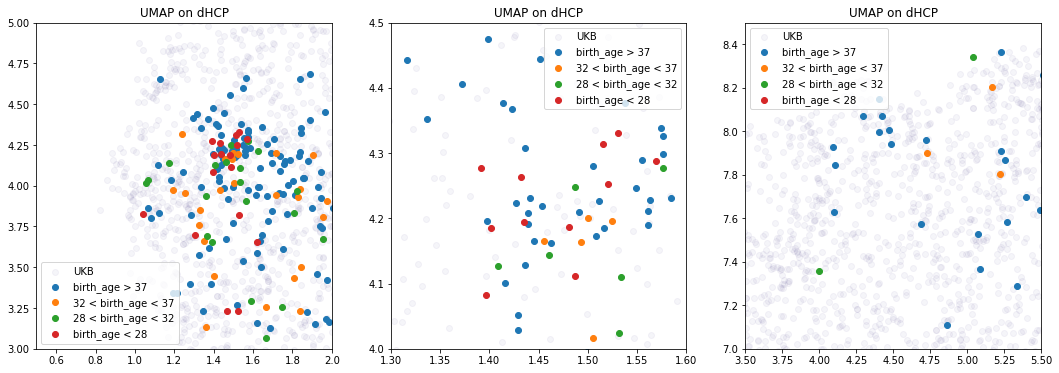

In [ ]:
# zoom on specific regions

label='birth_age'
thresholds=[28,32,37]
df_preterm = df.loc[df[label] <= threshold]
df_fullterm = df.loc[df[label] > threshold]

zooms = [(0.5, 2, 3, 5), (1.3, 1.6, 4, 4.5), (3.5, 5.5, 7, 8.5)]

fig, axs = plt.subplots(figsize=(6*len(zooms),6), ncols=len(zooms))

for zoom, ax in zip(zooms, axs):
    ax.set_xlim((zoom[0], zoom[1]))
    ax.set_ylim(zoom[2], zoom[3])
    ax.scatter(df_embeddings_0['dim1'], df_embeddings_0['dim2'], color='darkslateblue', label='UKB', alpha=0.05)
    plot_umap(df, label, thresholds, ax, transparency_full_term=1)

plt.show()

preterm density indeed appears high in cluster 

In [ ]:
# select a random sample in a cropped region

# region
crop = (1.4, 1.6, 4.1, 4.4)
#crop = (3.5, 5.5, 7, 8.5)

df_cropped = df.loc[(df['dim1'] > crop[0]) & (df['dim1'] < crop[1]) & (df['dim2'] > crop[2]) & (df['dim2'] < crop[3])]
df_cropped.shape
sample = df_cropped.sample()
print(sample)
print("directories anatomist:")
print("1. folds")
dir_to_visu = f"/neurospin/grip/external_databases/dHCP_CR_JD_2018/Projects/denis/release3_morpho_bids/sub-{sample['participant_id'].tolist()[0]}/ses-{sample['session_id'].tolist()[0]}/anat/t1mri/default_acquisition/default_analysis/"
print(dir_to_visu+f"/folds/3.1/default_session_auto/R{sample['participant_id'].tolist()[0]}_default_session_auto.arg")
print("2. mesh")
print(dir_to_visu+f"segmentation/mesh/{sample['participant_id'].tolist()[0]}_Rwhite.gii")

    participant_id  session_id  birth_age      dim1      dim2
112    CC00337XX16      107000  37.428571  1.439122  4.208577
directories anatomist:
1. folds
/neurospin/grip/external_databases/dHCP_CR_JD_2018/Projects/denis/release3_morpho_bids/sub-CC00337XX16/ses-107000/anat/t1mri/default_acquisition/default_analysis//folds/3.1/default_session_auto/RCC00337XX16_default_session_auto.arg
2. mesh
/neurospin/grip/external_databases/dHCP_CR_JD_2018/Projects/denis/release3_morpho_bids/sub-CC00337XX16/ses-107000/anat/t1mri/default_acquisition/default_analysis/segmentation/mesh/CC00337XX16_Rwhite.gii


## Regression

In [ ]:
## Save parameters of interest about the data
out_dir = '/neurospin/dico/jlaval/data/dHCP_155/params.csv'
subjects = pd.read_csv('/neurospin/dico/data/deep_folding/current/datasets/dHCP_374_subjects/crops/2mm/S.T.s.baby/mask/Rskeleton_subject.csv')
subjects = subjects['Subject'].tolist()
skels = np.load('/neurospin/dico/data/deep_folding/current/datasets/dHCP_374_subjects/crops/2mm/S.T.s.baby/mask/Rskeleton.npy')
skels = skels[:,:,:,:,0]
vol_list=[]
for idx, subject in enumerate(subjects):
    skel = skels[idx]
    vol = np.sum(skel > 0)
    vol_list.append(vol)
skel_vol_df = pd.DataFrame({'Subject': subjects,
                            'skel_volume': vol_list})
skel_vol_df.to_csv(out_dir, sep=',', index=False)

In [ ]:
#### PARAMS

# SimCLR
# dHCP subset
#dir = '/neurospin/dico/jlaval/Runs/01_deep_supervised/Program/Output/2023-06-13/13-33-26/STs_dHCP_155_embeddings/'
# dHCP 374
dir = '/neurospin/dico/jlaval/Runs/01_deep_supervised/Program/Output/2023-06-09/17-02-23_1/STs_dHCP_embeddings/'
# dHCP, variable foldlabel
#dir = '/neurospin/dico/jlaval/Runs/01_deep_supervised/Program/Output/2023-06-14//11-26-01/STs_dHCP_374_embeddings/'
#test_only=True
test_only=False
model='SimCLR'
#param_to_predict='birth_age'
param_to_predict='skel_volume'

# supervised, regresser
#dir = '/neurospin/dico/jlaval/Runs/01_deep_supervised/Program/Output/2023-06-13/13-42-14/STs_dHCP_155_embeddings/'
#test_only = True
#model='Regresser'
#param_to_predict='birth_age'
#param_to_predict='skel_volume'

####

dir_embeddings = dir+'full_embeddings.csv'
cols = [f'dim{k}' for k in range(1,11)]
df_embeddings = pd.read_csv(dir_embeddings, sep=',')
df_embeddings.columns=['Subject']+cols

label_dir = '/neurospin/dico/jlaval/data/dHCP_155/'
test = pd.read_csv(label_dir+'test_subject.csv', header=None)

if test_only:
    subjects = test.copy()
else: # use all subjects: train, test, val
    train = pd.read_csv(label_dir+'train_subject.csv', header=None)
    val = pd.read_csv(label_dir+'validation_subject.csv', header=None)
    subjects = pd.concat((train, val, test))
subjects.columns=['Subject']

# stack all info in df
param_dirs = []
param_dir = '/neurospin/dico/data/deep_folding/current/datasets/dHCP_374_subjects/crops/2mm/S.T.s.baby/mask/preterm_labels.csv'
param_dirs.append(param_dir)
param_dir = '/neurospin/dico/jlaval/data/dHCP_155/params.csv'
param_dirs.append(param_dir)

df = df_embeddings.copy()
for param_dir in param_dirs:
    param = pd.read_csv(param_dir)
    param_subset = param.loc[param['Subject'].isin(subjects['Subject'])]

    #reorder subjects by merging with embeddings
    df = pd.merge(df, param_subset)

#sort by ascending age
df = df.sort_values(by=param_to_predict, axis=0)
#keep track of the indices to compare volume and age distribution

(0.36571438876900003, 2.8773363607435176e-06)


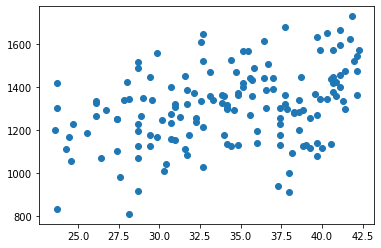

In [ ]:
age, volume = df['birth_age'], df['skel_volume']
plt.scatter(age, volume)
p = pearsonr(age, volume)
print(p)

[ 0.29349981  0.37740112 -0.18784224 -0.08498632  0.07883657  0.37117672
 -0.03340917  0.1399142  -0.0971265   0.12293314]


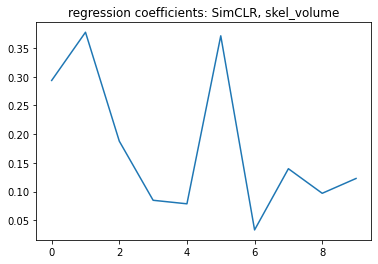

In [ ]:
X = df[cols].to_numpy()
y = df[param_to_predict].to_numpy()

# center and reduce X and y
for k in range(X.shape[1]):
    X[:, k] -= np.mean(X[:, k])
    X[:, k] = X[:, k] / np.max(np.abs(X[:, k]))

y = y - np.mean(y)
y = y / np.max(np.abs(y))

reg = LinearRegression().fit(X, y)

print(reg.coef_)
plt.plot(np.abs(reg.coef_))
plt.title(f'regression coefficients: {model}, {param_to_predict}')
plt.show()

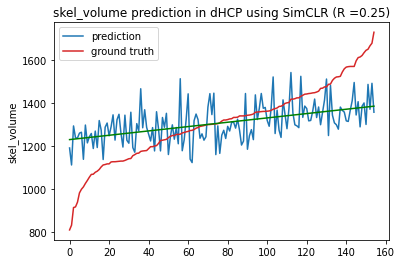

In [ ]:
# rescaled for plot (doesn't matter to normalize before, but the coefficients of the regression can be biased)
X = df[cols].to_numpy()
y = df[param_to_predict].to_numpy()
reg = LinearRegression().fit(X, y)
pred = reg.predict(X)
#trend of y
x = range(len(y))
z = np.polyfit(x,pred,1)
p = np.poly1d(z)
plt.plot(pred, color='tab:blue', label='prediction')
plt.plot(y, color='tab:red', label='ground truth')
plt.plot(x, p(x), color='green')
plt.ylabel(param_to_predict)
plt.legend()
plt.title(f'{param_to_predict} prediction in dHCP using {model} (R ={reg.score(X, y):.2f})')
plt.show()

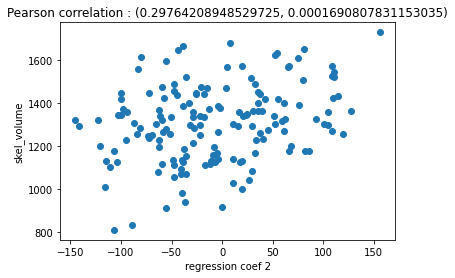

In [ ]:
# use the largest regression coeff to compute correlation with variable
coef = reg.coef_
idx = np.argmax(coef)
x = X[:, idx]
plt.scatter(x,y)
pearson = pearsonr(x,y)
plt.title(f'Pearson correlation : {pearson}')
plt.ylabel(param_to_predict)
plt.xlabel(f'regression coef {idx}')
plt.show()

In [ ]:
dict_pred = {'Subject': df['Subject'],
             param_to_predict: df[param_to_predict],
             'pred_'+param_to_predict: pred}
df_pred = pd.DataFrame(dict_pred)

In [ ]:
df_pred_ = df_pred.copy()

In [ ]:
df_pred = pd.merge(df_pred, df_pred_)

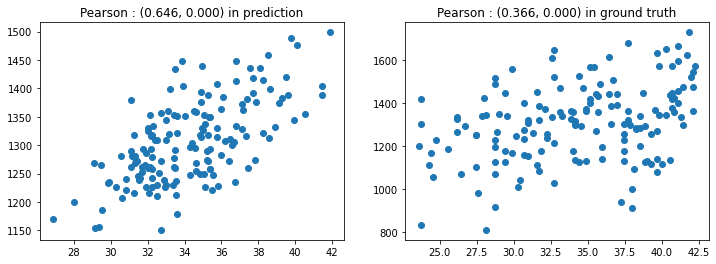

In [ ]:
# correlation between age and volume: predicted vs true ### ERROR IN THE CODE

# plot
fig,axs = plt.subplots(ncols=2, figsize=(12,4))
axs[0].scatter(df_pred['pred_birth_age'],df_pred['pred_skel_volume'])
p = pearsonr(df_pred['pred_birth_age'], df_pred['pred_skel_volume'])
axs[0].set_title(f'Pearson : ({p[0]:.3f}, {p[1]:.3f}) in prediction')
axs[1].scatter(df_pred['birth_age'], df_pred['skel_volume'])
p = pearsonr(df_pred['birth_age'], df_pred['skel_volume'])
axs[1].set_title(f'Pearson : ({p[0]:.3f}, {p[1]:.3f}) in ground truth')
plt.show()